In [30]:
from train.training_session_v0 import load_training_session
import multiprocessing
import torch

device = "cuda"

session = load_training_session(
    save_path="saves/phase1/ablation/delay/0_0/epoch_15",
    studies={"gwilliams2023": "audio"},
    data_path="data",
)

dataloader = session.get_dataloader(buffer_size=1, num_workers=1, max_cache_size=100)

recording = session.studies["gwilliams2023"].recordings[18][1][0]

print(
    f"Showing recording: {recording.study_name}_{recording.subject_id}_{recording.task_id}"
)

dataloader.start_fetching(recordings=[recording])
batch = dataloader.get_recording()
brain, audio, recording = (
    batch.brain_segments["all"].to(device),
    batch.audio_segments.to(device),
    batch.recording,
)

conditions = {
    "study": f"{recording.study_name}",
    "subject": f"{recording.study_name}_{recording.subject_id}",
}
session.model.to(device)

with torch.no_grad():
    pred, _ = session.model(
        x=brain, recording=recording, conditions=conditions, train=False
    )

dataloader.stop()

Loading Gwilliams2023 with batch type audio
Data partitioned on studies ['gwilliams2023'].
Train: 135, Unseen Task: 12, Unseen Subject: 45, Unseen Both: 4.

GPU is not NVIDIA V100, A100, or H100. Speedup numbers may be lower than expected.
SimpleConv initialized with 8448160 parameters, cond: ['study', 'subject']
Merger False, merger channels 0
ConvBlocks: 6, hidden_dim: 384, params 7973376
Showing recording: Gwilliams2023_19_0


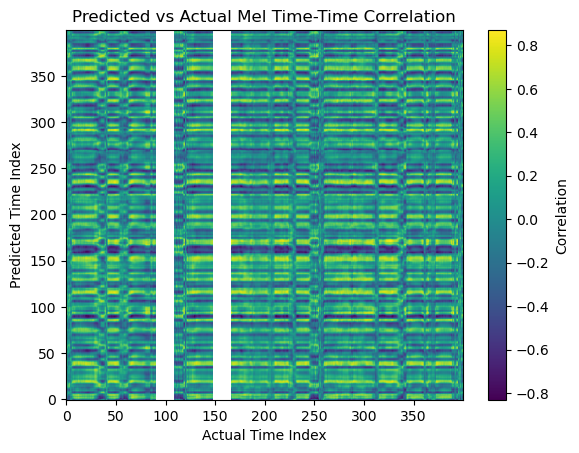

In [35]:
import numpy as np
import matplotlib.pyplot as plt


def compute_time_time_correlation(target, predicted):
    """
    Compute a T x T correlation matrix between predicted and actual mel frames.
    pred_mel and actual_mel should both be [C, T].
    """
    pred_t = predicted.T  # shape: [T, C]
    target_t = target.T  # shape: [T, C]

    T = pred_t.shape[0]
    corr_matrix = np.zeros((T, T))

    for i in range(T):
        for j in range(T):
            # Pearson correlation between pred_T[i] and actual_T[j]
            corr = np.corrcoef(pred_t[i], target_t[j])[0, 1]
            corr_matrix[i, j] = corr

    return corr_matrix


index = 0

predicted_mel = pred[index].cpu().numpy()
actual_mel = audio[index].cpu().numpy()

corr = compute_time_time_correlation(actual_mel, predicted_mel)

# Plot
plt.imshow(corr, origin="lower", aspect="auto", cmap="viridis")
plt.colorbar(label="Correlation")
plt.xlabel("Actual Time Index")
plt.ylabel("Predicted Time Index")
plt.title("Predicted vs Actual Mel Time-Time Correlation")
plt.show()

In [29]:
import copy

delay_corr = copy.deepcopy(corr)

In [32]:
no_delay_corr = copy.deepcopy(corr)

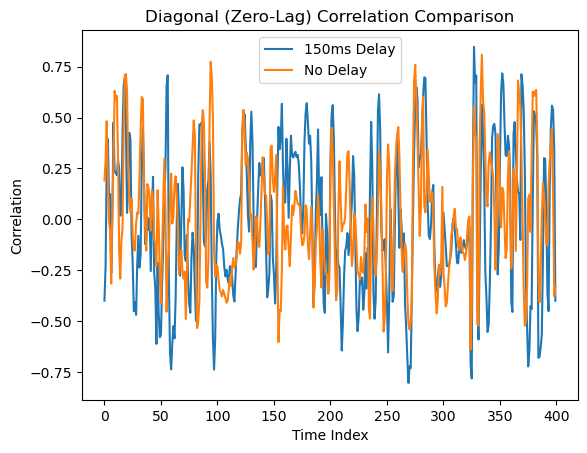

In [34]:
diag_delay = np.diag(delay_corr)
diag_no_delay = np.diag(no_delay_corr)

plt.plot(diag_delay, label="150ms Delay")
plt.plot(diag_no_delay, label="No Delay")
plt.xlabel("Time Index")
plt.ylabel("Correlation")
plt.title("Diagonal (Zero-Lag) Correlation Comparison")
plt.legend()
plt.show()

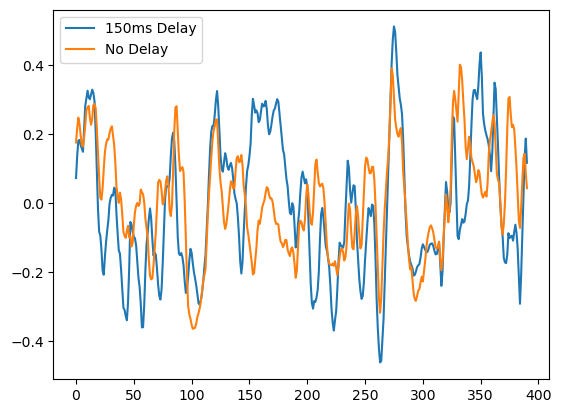

In [36]:
def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), "valid") / w


smoothed_delay = moving_average(diag_delay, w=10)
smoothed_no_delay = moving_average(diag_no_delay, w=10)

plt.plot(smoothed_delay, label="150ms Delay")
plt.plot(smoothed_no_delay, label="No Delay")
plt.legend()
plt.show()

In [37]:
mean_delay = np.mean(diag_delay)
mean_no_delay = np.mean(diag_no_delay)
std_delay = np.std(diag_delay)
std_no_delay = np.std(diag_no_delay)

print(f"150ms Delay: mean={mean_delay:.3f}, std={std_delay:.3f}")
print(f"No Delay: mean={mean_no_delay:.3f}, std={std_no_delay:.3f}")

150ms Delay: mean=-0.008, std=0.356
No Delay: mean=0.009, std=0.298


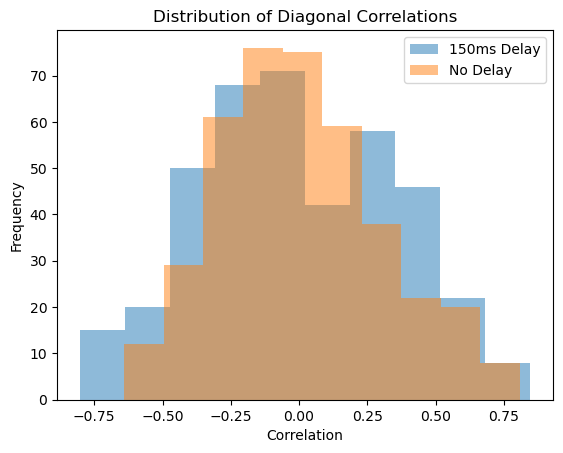

In [38]:
plt.hist(diag_delay, alpha=0.5, label="150ms Delay")
plt.hist(diag_no_delay, alpha=0.5, label="No Delay")
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Diagonal Correlations")
plt.show()

In [39]:
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(diag_delay, diag_no_delay)
print(f"Paired t-test: t={t_stat:.3f}, p={p_val:.3f}")

Paired t-test: t=-0.936, p=0.350


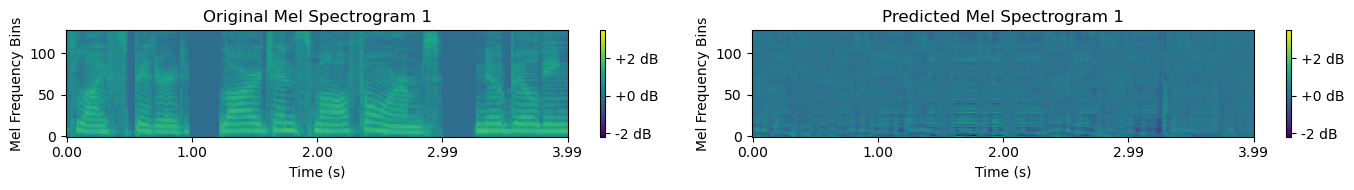

In [21]:
from utils.plot import mel_spectrogram

mel_spectrogram(
    x=audio[index : index + 1].to("cpu"),
    max_plots=1,
    x_pred=pred[index : index + 1].to("cpu"),
)

In [3]:
audio.max(), audio.min(), audio.mean(), pred.max(), pred.min(), pred.mean()

(tensor(1.9549, device='cuda:0'),
 tensor(-0.2430, device='cuda:0'),
 tensor(0.4793, device='cuda:0'),
 tensor(10.9885, device='cuda:0'),
 tensor(-5.4988, device='cuda:0'),
 tensor(0.0064, device='cuda:0'))

In [4]:
# from utils.plot import plot_training_metrics
# plot_training_metrics(session.metrics)